# Tutorial 3: An Introduction to Keras
This tutorial covers 
- [What's Keras?](#sec-1)
- [Example: Regression problem](#sec-2)
- [Exercise: Muticlass classification problem](#sec-3)

## What's Keras? <a class="anchor" id="sec-1"></a>
Keras ([https://keras.io](https://keras.io)) is a deep learning API for Python. It is built on top of Tensorflow ([https://www.tensorflow.org/](https://www.tensorflow.org/)), and its primary purpose is to enable fast experimentation by offering simple workflows. Keras is great for learning and will suffice for many applied deep learning projects.

TensorFlow is one of the most popular and powerful deep learning frameworks, but its use is more complicated when compared to Keras. For ADAMS, simplicity rules and matters more than the greater flexibility Tensorflow or other popular frameworks like [PyTorch](https://pytorch.org/), [MXNet](https://mxnet.apache.org/) have to offer. 

Let's start with Keras. To that end, we will first present the anatomy of Neural Networks from Keras's perspective. Then, we will illustrate its use with a regression example and let you get your hands-on with a multiclass classification exercise. 

### Keras's perspective
In Keras, the main class is the `Layer`. A layer is a module that transforms tensors, like LEGO bricks. The type of the layer depends on the tensor format and the type of data. For example, 
- Rank-2 tensor (samples, features) &rarr; dense layer (`Dense`).
- Rank-3 tensor, such as sequence data, (samples, time, features) &rarr; recurrent layer (`LSTM`, `Conv1D`).
- Rank-4 tensor, e.g. images &rarr; 2D convolution layer (`Conv2D`).

`Layers` are assembled into the `Model` class. A deep learning model is not more than a graph of layers. For example, a model can be a stack of layers mapping a single input to a single output. That corresponds to the subclass of `Model` called `Sequential` in Keras. For example,

```python
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1) # it does not have activation (linear layer by default)
])
```

However, as long as we dive further in the course, we will find other network topologies, including two-branch networks, residual connections, etc. 

Before training your model, you will need to decide
- which `optimizer` (`RMSprop`, `SGD`, etc.) you to use, 
- which `loss` function is adequate for the problem (`MeanSquaredError`, `CategoricalCrossentropy`, etc.), and 
- what `metrics` you want to monitor (`MAE`, `Accuracy`, etc.). 

All three are specified through the `compile()` method. 

Next, you'll use the `fit()` method to train the model. This method implements the loop itself, and its key arguments are the `data`, the number of `epochs`, and the `batch` size. Here we can also monitor the loss and metrics on the `validation` data.

Finally, when the model is trained, we want to use it in new data. To this end, we use the method `predict()` to generate predictions on new data.

## Example: Regression problem <a class="anchor" id="sec-2"></a>
Let's learn how to use Keras with an example. The idea is to predict the median value of owner-occupied homes (in thousands of dollars) in a Boston suburb, given features such as crime rate, the average number of rooms, and so forth. We structure the task in 5 steps:
1. Get the dataset.
2. Prepare the data for the training. Here we transform the data to be suitable for a neural network.
3. Build the model. We create the layers (`Dense` layer), graph (`Sequential` model) and compile the model (`compile()`).
4. Validate the approach. We commonly use training and validation sets to tune our model (`fit()`). Then, retrain the model with the fine-tuned parameters and evaluate the model in the test set.
5. Make predictions on a new dataset. Commonly on the test set (`predict()`).

### 1. Get the dataset
Let's load the data

In [1]:
from tensorflow.keras.datasets import boston_housing
# this will split the data 80-20% by default
(x_train, y_train), (x_test, y_test) = boston_housing.load_data()
# if you want to try out different options, do the following
# import tensorflow as tf
# (x_train, y_train), (x_test, y_test) = tf.keras.datasets.boston_housing.load_data(path="boston_housing.npz", test_split=0.2, seed=113)

In [2]:
# Let's take a look at the shape of the data
print('Shape of train data:',x_train.shape,
'\nShape of test data:', x_test.shape)

Shape of train data: (404, 13) 
Shape of test data: (102, 13)


In [3]:
# Let's take a look at the features
import pandas as pd
pd.DataFrame(x_train).describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12
count,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000,404.000000
mean,3.745111,11.480198,11.104431,0.061881,0.557356,6.267082,69.010644,3.740271,9.440594,405.898515,18.475990,354.783168,12.740817
std,9.240734,23.767711,6.811308,0.241238,0.117293,0.709788,27.940665,2.030215,8.698360,166.374543,2.200382,94.111148,7.254545
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,188.000000,12.600000,0.320000,1.730000
25%,0.081437,0.000000,5.130000,0.000000,0.453000,5.874750,45.475000,2.077100,4.000000,279.000000,17.225000,374.672500,6.890000
50%,0.268880,0.000000,9.690000,0.000000,0.538000,6.198500,78.500000,3.142300,5.000000,330.000000,19.100000,391.250000,11.395000
75%,3.674808,12.500000,18.100000,0.000000,0.631000,6.609000,94.100000,5.118000,24.000000,666.000000,20.200000,396.157500,17.092500
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.725000,100.000000,10.710300,24.000000,711.000000,22.000000,396.900000,37.970000


The descriptions of the features are the following (more details about this dataset can be found in [http://lib.stat.cmu.edu/datasets/boston](http://lib.stat.cmu.edu/datasets/boston))
| # | Variable | Description |
|---|---|---|
| 1 | CRIM | per capita crime rate by town |
| 2 | ZN | proportion of residential land zoned for lots over 25,000 sq.ft. |
| 3 | INDUS | proportion of non-retail business acres per town |
| 4 | CHAS | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
| 5 | NOX | nitric oxides concentration (parts per 10 million) |
| 6 | RM | average number of rooms per dwelling |
| 7 | AGE | proportion of owner-occupied units built prior to 1940 |
| 8 | DIS | weighted distances to five Boston employment centres |
| 9 | RAD | index of accessibility to radial highways |
| 10 | TAX | full-value property-tax rate per $10,000 |
| 11 | PTRATIO | pupil-teacher ratio by town |
| 12 | B | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town |
| 13 | LSTAT | % lower status of the population |

So, we have 404 samples to train and 102 to test, each with 13 numerical features. The target is the median values of homes. Let's have a quick look at them

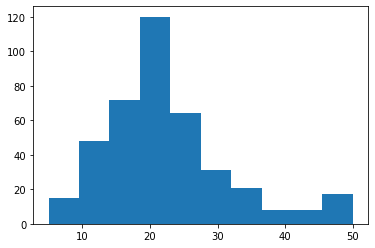

In [4]:
import matplotlib.pyplot as plt
plt.hist(y_train)
plt.show()

The prices are between 10K and 50K. That seems cheap! However, the data is from the mid-1970s. 

### 2. Data preparation
We saw that `x_train` takes different ranges. This is problematic for neural networks, so a common practice is to normalize each feature. This means that for each column, we subtract its mean and divide it by its standard deviation. Let's do that

In [5]:
mean = x_train.mean(axis=0) # axis 0, along the rows or column-wise operation
std = x_train.std(axis=0)
x_train -= mean # substract the mean
x_train /= std # divide by the stdev
# apply this very same transformation to the test set (never compute on test set!)
x_test -= mean
x_test /= std

### 3. Building the model
We are ready to build our model. Since the sample size is small, two layers with 64 units will be enough to avoid overfitting. Each layer has `relu` activation function. Moreover, since the target is price, we use `linear` activation for the output of the neural network

In [6]:
from tensorflow import keras
from tensorflow.keras import layers
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1) # it does not have activation (linear layer)
])

2022-05-05 17:42:01.213315: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


We have specified the architecture of the network. Now, let's compile our model using *Root Mean Square propagation* (`RMSprop`) as the optimization algorithm. Of course, there are many other alternatives for the `optimizer`, such as `SGD`, `Adam`, `Adadelta`, etc. (see [https://keras.io/api/optimizers/](https://keras.io/api/optimizers/)).

We use the Mean Square Error as the loss (`mse`) (see [https://keras.io/api/losses/](https://keras.io/api/losses/) for other alternatives). We also track the Mean Absolute Error (`mae`) defined in `metrics`. 

In [7]:
model.compile(optimizer='RMSprop', 
    loss='mse', # mean squared error, widely used for regression problems
    metrics=['mae']) # we are also monitoring the mean absolute error 

### 4. Validate the approach
In this step, we fit the model. To do it, we first create a validation set from the train data. For example, we can use the first quarter of the training data

In [8]:
num_val_samples = len(x_train) // 4 
x_val = x_train[0:num_val_samples]
y_val = y_train[0:num_val_samples]
x_train_aux = x_train[num_val_samples:]
y_train_aux = y_train[num_val_samples:]

For the training we use 100 epochs and a batch size of 16

In [9]:
history = model.fit(x_train_aux,
                    y_train_aux,
                    epochs = 100,
                    batch_size = 16,
                    validation_data= (x_val, y_val), # also possible `validation_split = 0.25`
                    verbose = 0) # change it to 1 if we want to see how the loss is optimized

2022-05-05 17:42:15.527961: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)


Let's plot the training and validation loss

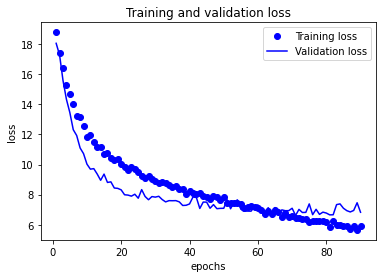

In [10]:
loss = history.history["loss"] # retrieve the loss in the training set
val_loss = history.history["val_loss"] # retrieve the loss in the validation set
trunc_loss = loss[10:] # just to zoom in and see the differences
trunc_val_loss = val_loss[10:]
epochs = range(1, len(trunc_loss)+1)
plt.plot(epochs, trunc_loss, "bo", label = "Training loss")
plt.plot(epochs, trunc_val_loss, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.legend()
plt.show()

It seems that around 60 epochs, there is not much improvement. We can now train the final model on all training data using 60 epochs, and then we evaluate it on the test data.

In [11]:
model = keras.Sequential([
    layers.Dense(64, activation="relu"),
    layers.Dense(64, activation="relu"),
    layers.Dense(1) # it does not have activation (linear layer)
])
model.compile(optimizer='rmsprop', 
    loss='mse', # mean squared error, widely used for regression problems
    metrics=['mae']) # we are also monitoring the mean absolute error 
model.fit(x_train,
    y_train,
    epochs = 60,
    batch_size=16,
    verbose=0)
results = model.evaluate(x_test, y_test)

4/4 [==============================] - 0s 1ms/step - loss: 18.2243 - mae: 2.8630


Hence, we reached a MAE of 2.6. This means we are off around $2,600 in our predictions. 

### 5. Generate predictions on new data
The function `predict()` returns the predicted median price of the houses (in $1,000).

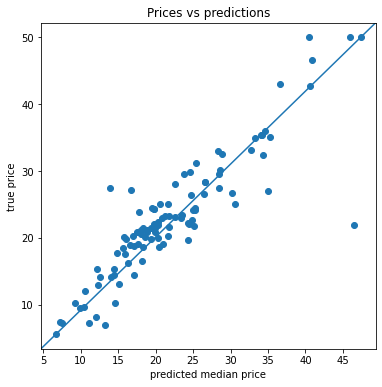

In [12]:
predictions = model.predict(x_test)

# Let's plot the true prices versus the predictions
f, ax = plt.subplots(figsize=(6, 6))
ax.scatter(predictions, y_test)
ax.plot([0, 1], [0, 1], transform=ax.transAxes) # add diagonal as a reference
plt.title("Prices vs predictions")
plt.xlabel("predicted median price")
plt.ylabel("true price")
plt.show()

## Exercise: Multiclass classification  <a class="anchor" id="sec-3"></a>
The goal is to build a model that classifies news (text data) into 46 mutually exclusive categories. Since each news item is classified in only one category, the problem is *single-label multiclass classification*. On the other hand, if we wanted, for example, to build a model that allows each news item to be classified into more than one category, it would be a *multilabel multiclass classification* problem.

### 1. Get the dataset
#### Exercise 1 
Load the `reuters` dataset, available from `tensorflow.keras.datasets `. 
To limit the data size, filter the 10,000 most frequently occurring words using the argument `num_words=10000` in the `load_data` module. Split the data 80/20 as before and have a look at how many examples each dataset has.

In [ ]:
# Load reuters dataset
import warnings
import numpy as np
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

#### Exercise 2
Print the first example from the training dataset to see that are a list of integers. Next, using the `reuters.get_word_index()` create a dictionary to retrieve the words and recreate the news article for the first example. You will need to lag the indices by 3 because the first 3 are reserved for *padding*, *start of sequence* and *unknown*.

In [13]:
# The examples are a list of integers. Each integer represents a word index.

In [14]:
# Create a dictionary and convert x_train[0] to sequence of words


#### Exercise 3 
Create a frequency table to count how many examples are per category in the training dataset (you can use `np.unique` and `np.asarray` for example).

In [15]:
## let's see the labels

### 2. Data preparation
The training examples are lists of integers, all with different lengths. However, we can't directly input lists of integers with different lengths into a neural network. So, we need to transform them, and to do so we have two options:
1. Pad our lists to let them all with the same length, e.g. a tensor with shape `(samples, max_length)`.
2. Multi-hot encoding our lists to transform them into vectors of 0s and 1s with a length equal to the size of the vocabulary. In our case, 10,000.
The first option will need a layer called `Embedding` (cover later in the course). The second option can be handled with the `Dense` layer and is the one we'll use.  

#### Exercise 4
Create a function called `to_multi_hot_encoding` that takes the list of integers and outputs a multi-hot encoding matrix of size `(samples, vacabulary_dim)`. For example, if the list of integers is `[2,1,5,5]` and the vocabulary has 10 words, the function should give us `[0., 1., 1., 0., 0., 1., 0., 0., 0., 0.]`. Once created, encode `x_train` and `x_test` and call these new object `x_train_enc` and `x_test_enc`, respectively.

In [16]:
# # create to_multi_hot_encoding function
# def to_multi_hot_encoding(lists_int, dim = 10000):

# # convert x_train and x_test
# x_train_enc = to_multi_hot_encoding(x_train)
# x_test_enc = to_multi_hot_encoding(x_test)
# x_train_enc[0]

#### Exercise 5
Now we need to vectorize the labels. To do so, we also have two options
1. We can cast the label list as an integer tensor (later). 
2. We can use one-hot encoding, also called categorical encoding. 

Create a new function called `to_one_hot_encoding` that does the encoding. Then, apply it to `y_train` and `y_test` to create `y_train_enc` and `y_test_enc`, respectively.

In [17]:
# create to_one_hot_encoding


### 3. Building the model

#### Exercise 6
Build a 3 stack of sequential `Dense` layers where
- The first and second layers have 64 units and `relu` activation. What happens if the number of units is lower than the number of categories?
- The final layer has the right dimension and a `softmax` activation function. 
- Use `rmsprop` as optimizer, `categorical_crossentropy` as loss function and record `accuracy`.

In [18]:
# Define model

# Compile model

### 4. Validate the approach
#### Exercise 7
- Use the first 2,000 samples from the training data as the validation set.
- Train the model for 15 epochs with a batch size of 512. Save the history in `history`

In [19]:
# Create validation set


# Fit the model


#### Exercise 8
Plot the training and validation loss to see when the model starts to overfit

In [20]:
## Plot training and validation loss


#### Exercise 9
Re-train the model for the whole training data, using an adequate number of epochs.

In [21]:
# Re-train the model from scratch


#### Exercise 10
Evaluate the model in the test data. How accurate is the model?

In [22]:
# Evaluate on test data


### 5. Generate predictions
#### Exercise 11
Generate predictions for the test set and print the first example. Which class is the most probable? 


In [23]:
# Generate predictions


#### Exercise 12
Get the predicted classes (use `np.argmax` function) and compare them with the true ones

In [24]:
# Get the predicted class


## Summing up
We have seen simple cases of the use of Keras. In all of them, the main steps were

```python
# Define model
model = keras.Sequential([
    layers.Dense(n_units, activation),
    ...,
    ...
])
# Compile
model.compile(optimizer,
    loss,
    metrics
)
# Train
model.fit(x_train,
    y_train,
    epochs,
    batch_size)
# Evaluate 
model.evaluate(x_test, y_test)
# Predict
model.predict(x_new)
```

Keras has many other features, and we will see more in the upcoming sessions! 